In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 6.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=386e8ae6eaf05b419a8dc37d559c71306ecfd0e8646111649abf6b29506927c2
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!mkdir /root/.kaggle/

In [ ]:
pwd

'/content'

In [ ]:
!cp /content/kaggle.json /root/.kaggle   
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.75G/5.76G [02:01<00:00, 40.1MB/s]
100% 5.76G/5.76G [02:01<00:00, 51.0MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip
!unzip cassava-leaf-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/3954399974.jpg  
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  in

In [ ]:
import pandas as pd
import shutil
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('bmh')
import random
import glob
from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import Dense,Activation,Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from keras.models import Model
# tf.enable_eager_execution()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from numpy.random import seed
seed(1)
from tensorflow import random
#random.set_seed(1)
#from tensorflow import set_random_seed    
#tf.set_random_seed(2)
from numpy.random import seed 
seed(42)# keras seed fixing import tensorflow as tf tf.random.set_seed(42)# tensorflow seed fixing
tf.config.run_functions_eagerly(True)
import seaborn as sns
import glob
import shutil
#np.random.seed
from keras import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D,Dense, Dropout

from sklearn.model_selection import train_test_split

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
#BATCH_SIZE = 16
#IMAGE_SIZE = [512, 512]
IMAGE_SIZE = [224, 224] #for cropnet
AUTOTUNE = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 8
#STEPS_PER_EPOCH = len(training_data)*0.6 / BATCH_SIZE
#VALIDATION_STEPS = len(validation_data)*0.4/ BATCH_SIZE
#VALIDATION_STEPS = 100
EPOCHS = 50
TARGET_SIZE = 512
#TARGET_SIZE = 300

In [ ]:
img_width = 299
img_height = 299
img_width1 = 224
img_height1 = 224
Inception_weight = "/content/drive/MyDrive/inception_ (1).h5"
#Inception2 = "/content/inception_ (1).h5"


In [ ]:
#create teacher and student models
Inception_layer1 = tf.keras.applications.InceptionResNetV2(include_top=False,input_shape=(img_width1, img_height1, 3))
MobileNet_layer1 = tf.keras.applications.MobileNet(include_top=False, weights ='imagenet', alpha=1.0, input_shape=(img_width1, img_height1,3))

17227776/17225924 [==============================] - 1s 0us/step


In [ ]:
#create teacher and student models
# Create the teacher
teacher = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_width1, img_height1,3)),
  Inception_layer1,
  tf.keras.layers.GlobalAveragePooling2D(),     
  tf.keras.layers.Dense(5, activation = "softmax")
], 
  name = "teacher",
  )

# Create the student
student = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_width1,img_height1,3)),
        MobileNet_layer1,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation = 'relu'),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(5, activation = 'softmax')
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

In [ ]:
# Prepare the train and test dataset.
df = pd.read_csv("train.csv")

In [ ]:

df.label = df.label.astype('str')

#train_df, test_df = train_test_split(df, test_size=0.3)
train_df, test_df = train_test_split(df, test_size=0.4, random_state=11)
#val_df, test_df = train_test_split(test_df, test_size=0.5)

In [ ]:
len(train_df)

12838

In [ ]:
len(test_df)

8559

In [ ]:
train_df['label'].value_counts()

3    7932
4    1521
2    1434
1    1297
0     654
Name: label, dtype: int64

In [ ]:
test_df['label'].value_counts()

3    5226
4    1056
2     952
1     892
0     433
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
Train_dir = '/content/train_images/'

In [ ]:
#splitting the data using stratified cross validation
Y = train_df['label']

kf = KFold(n_splits = 3)
                         
skf = StratifiedKFold(n_splits = 3, random_state = 7, shuffle = True) 

In [ ]:
idg = ImageDataGenerator(
    validation_split = 0.2,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    #channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=None,
    )

vdg =ImageDataGenerator(rescale=1./255,validation_split=0.15)
tdg = ImageDataGenerator(rescale = 1./255)

In [ ]:
#getting folds and creating data generators
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []

save_dir = '/content/saved_models/'
fold_var = 1
n = 12838

for train_index, val_index in skf.split(np.zeros(n),Y):
	training_data = train_df.iloc[train_index].astype(str)
	validation_data = train_df.iloc[val_index].astype(str)
 
 
	
	train_data_generator = idg.flow_from_dataframe(training_data, directory = Train_dir,
						       x_col = "image_id", y_col = "label", batch_size = BATCH_SIZE, target_size=(224,224),
						       class_mode = "sparse", seed=42, shuffle = True)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = Train_dir,
							x_col = "image_id", y_col = "label", batch_size = BATCH_SIZE,target_size=(224,224),
							class_mode = "sparse", seed=42, shuffle = True)
 
 

Found 8558 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.
Found 8559 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.
Found 8559 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [ ]:
test_data = test_df.astype(str)

test_data_generator = idg.flow_from_dataframe(test_df, directory = Train_dir, target_size=(224,224),
              batch_size = BATCH_SIZE, x_col = "image_id", y_col = "label", seed=42, class_mode="sparse")

Found 8559 validated image filenames belonging to 5 classes.


In [ ]:
# data augmentation
aug_images = [train_data_generator[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

**Train the teacher**

In [ ]:
# Train teacher as usual
teacher.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             metrics=['accuracy'])


In [ ]:
#call backs
model_save = tf.keras.callbacks.ModelCheckpoint('./inception_resnet_50.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [ ]:
history_teacher = teacher.fit(train_data_generator,
			    epochs=EPOCHS,
			    validation_data=valid_data_generator,
          callbacks=[model_save, early_stop], shuffle=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/50
1070/1070 [==============================] - 735s 671ms/step - loss: 0.9214 - accuracy: 0.6669 - val_loss: 0.8939 - val_accuracy: 0.7343

Epoch 00001: val_loss improved from inf to 0.89394, saving model to ./inception_resnet_50.h5
Epoch 2/50
1070/1070 [==============================] - 699s 653ms/step - loss: 0.6628 - accuracy: 0.7704 - val_loss: 0.8773 - val_accuracy: 0.7570

Epoch 00002: val_loss improved from 0.89394 to 0.87726, saving model to ./inception_resnet_50.h5
Epoch 3/50
1070/1070 [==============================] - 708s 661ms/step - loss: 0.5781 - accuracy: 0.7976 - val_loss: 0.5599 - val_accuracy: 0.8000

Epoch 00003: val_loss improved from 0.87726 to 0.55995, saving model to ./inception_resnet_50.h5
Epoch 4/50
1070/1070 [==============================] - 702s 656ms/step - loss: 0.5292 - accuracy: 0.8091 - val_loss: 0.7486 - val_accuracy: 0.7670

Epoch 00004: val_loss did not improve from 0.55995
Epoch 5/50
1070/1070 [==============================] - 680s 636ms

In [ ]:
 teacher.save('/content/inception_resnet_50.h5')

In [ ]:
new_model = tf.keras.models.load_model('/content/inception_resnet_50.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
new_model.evaluate(test_data_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1070/1070 [==============================] - 252s 235ms/step - loss: 0.5261 - accuracy: 0.8209


[0.5260859131813049, 0.8208903074264526]

In [ ]:
teacher.evaluate(test_data_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1070/1070 [==============================] - 251s 235ms/step - loss: 0.5256 - accuracy: 0.8211


[0.5255518555641174, 0.8211239576339722]

**Distill teacher to student**

In [ ]:
test_data_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

In [ ]:
x,y = train_data_generator.next()

In [ ]:
#construct the distiller class
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature


    def train_step(self, data):
        # Unpack data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    

    def call (self, data):
        #teacher_predictions = self.teacher(data, training=False)
        student_predictions = self.student(data, training=True)
        return student_predictions


    def test_step(self, data):
        # Unpack the data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results



In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
hist = distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1, temperature = 10
  
)

In [ ]:
# Distill teacher to student
hist = distiller.fit(train_data_generator, epochs=15, shuffle=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/15
1070/1070 [==============================] - 334s 311ms/step - sparse_categorical_accuracy: 0.6342 - student_loss: 0.9725 - distillation_loss: 3.2663e-04
Epoch 2/15
1070/1070 [==============================] - 332s 310ms/step - sparse_categorical_accuracy: 0.6979 - student_loss: 0.8246 - distillation_loss: 2.6665e-04
Epoch 3/15
1070/1070 [==============================] - 331s 309ms/step - sparse_categorical_accuracy: 0.7144 - student_loss: 0.7824 - distillation_loss: 2.5013e-04
Epoch 4/15
1070/1070 [==============================] - 332s 310ms/step - sparse_categorical_accuracy: 0.7255 - student_loss: 0.7536 - distillation_loss: 2.3550e-04
Epoch 5/15
1070/1070 [==============================] - 332s 310ms/step - sparse_categorical_accuracy: 0.7549 - student_loss: 0.6918 - distillation_loss: 2.0834e-04
Epoch 6/15
1070/1070 [==============================] - 332s 310ms/step - sparse_categorical_accuracy: 0.7546 - student_loss: 0.6851 - distillation_loss: 2.0847e-04
Epoch 7/15

In [ ]:
hist.history

{'distillation_loss': [0.00019012813572771847,
  0.00025974257732741535,
  0.0006475987611338496,
  0.00033656685263849795,
  0.00022393099789042026,
  0.00016063889779616147,
  0.00011542130232555792,
  0.0008204664336517453,
  0.00033789584995247424,
  0.0003848049382213503,
  2.482497257005889e-05,
  0.0004181997792329639,
  2.4852701244526543e-05,
  0.00015642648213542998,
  9.291951573686674e-05],
 'sparse_categorical_accuracy': [0.6506600975990295,
  0.6977450847625732,
  0.7200607657432556,
  0.729290783405304,
  0.7566304206848145,
  0.7603691816329956,
  0.7749736905097961,
  0.7706508040428162,
  0.780114471912384,
  0.7927327752113342,
  0.7941348552703857,
  0.7937843203544617,
  0.8017292022705078,
  0.8042995929718018,
  0.8094403743743896],
 'student_loss': [0.55360347032547,
  0.8944070935249329,
  1.7625062465667725,
  0.7288069128990173,
  0.4143724739551544,
  0.6796762347221375,
  0.9217449426651001,
  1.5756162405014038,
  0.6333174109458923,
  1.1018874645233154,


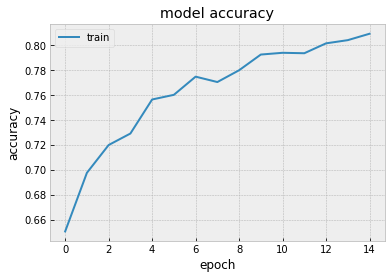

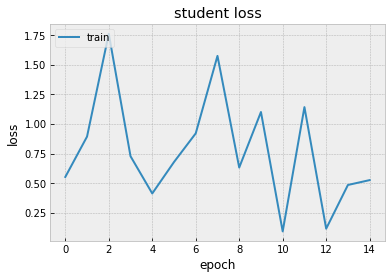

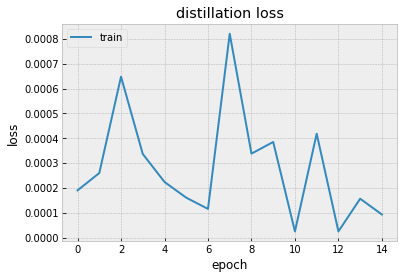

In [ ]:
#summary history for accuracy
plt.plot(hist.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for loss
plt.plot(hist.history['student_loss'])
#plt.plot(history.history['val_loss'])
plt.title('student loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for distillation loss
plt.plot(hist.history['distillation_loss'])
#plt.plot(history.history['val_loss'])
plt.title('distillation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
# Evaluate student on test dataset
distiller.evaluate(test_data_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1070/1070 [==============================] - 168s 157ms/step - sparse_categorical_accuracy: 0.8054 - student_loss: 0.5593


[0.8053510785102844, 0.2670384347438812]

In [ ]:
#construct the distiller class
class Distiller1(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller1, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller1, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature


    def train_step(self, data):
        # Unpack data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    
    def call (self, data):
        #teacher_predictions = self.teacher(data, training=False)
        student_predictions = self.student(data, training=True)
        return student_predictions


    def test_step(self, data):
        # Unpack the data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
# Initialize and compile distiller
distiller_1 = Distiller1(student=student, teacher=teacher)
hist = distiller_1.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1, temperature = 10
  
)

In [ ]:
#Early stopping using distillation loss
#call backs
model_save = tf.keras.callbacks.ModelCheckpoint('./teacher_inception_50.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'distillation_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'distillation_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [ ]:
# Distill teacher to student
hist2 = distiller_1.fit(train_data_generator, epochs=30,callbacks=[model_save, early_stop], shuffle=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/30
1070/1070 [==============================] - 339s 317ms/step - sparse_categorical_accuracy: 0.8219 - student_loss: 0.5135 - distillation_loss: 1.3956e-04

Epoch 00001: distillation_loss improved from inf to 0.00021, saving model to ./teacher_inception_50.h5
Epoch 2/30
1070/1070 [==============================] - 339s 316ms/step - sparse_categorical_accuracy: 0.8248 - student_loss: 0.5144 - distillation_loss: 1.4062e-04

Epoch 00002: distillation_loss improved from 0.00021 to 0.00001, saving model to ./teacher_inception_50.h5
Epoch 3/30
1070/1070 [==============================] - 336s 314ms/step - sparse_categorical_accuracy: 0.8296 - student_loss: 0.5096 - distillation_loss: 1.4146e-04

Epoch 00003: distillation_loss did not improve from 0.00001
Epoch 4/30
1070/1070 [==============================] - 333s 311ms/step - sparse_categorical_accuracy: 0.8226 - student_loss: 0.4958 - distillation_loss: 1.3603e-04

Epoch 00004: distillation_loss did not improve from 0.00001
Epoch 

In [ ]:
hist2.history

{'distillation_loss': [0.00021086180640850216,
  1.1675419045786839e-05,
  0.00027847790624946356,
  0.00014239430311135948,
  0.00017329795809928328,
  9.428490011487156e-05],
 'sparse_categorical_accuracy': [0.8201892971992493,
  0.8221755027770996,
  0.8217081427574158,
  0.8248627185821533,
  0.8371304869651794,
  0.8322234153747559],
 'student_loss': [0.4473961293697357,
  0.24898914992809296,
  0.9493436217308044,
  0.1733008474111557,
  0.5199545621871948,
  0.4831252992153168]}

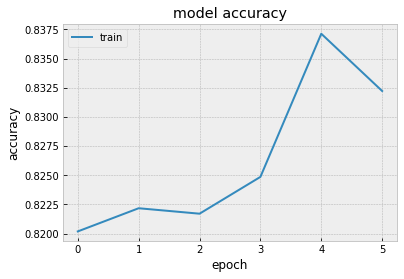

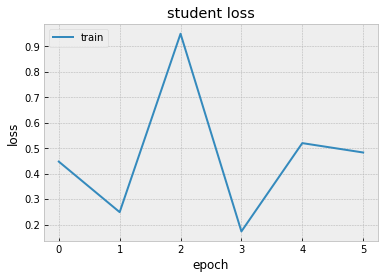

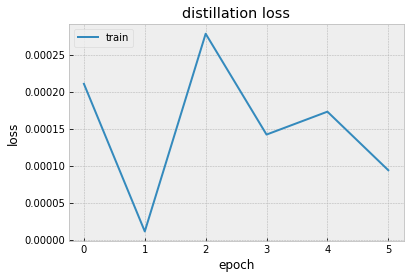

In [ ]:
#summary history for accuracy
plt.plot(hist2.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for loss
plt.plot(hist2.history['student_loss'])
#plt.plot(history.history['val_loss'])
plt.title('student loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for distillation loss
plt.plot(hist2.history['distillation_loss'])
#plt.plot(history.history['val_loss'])
plt.title('distillation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
distiller_1.evaluate(test_data_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1070/1070 [==============================] - 167s 156ms/step - sparse_categorical_accuracy: 0.8207 - student_loss: 0.5111


[0.8206565976142883, 0.9449617266654968]

In [ ]:
#construct the distiller class
class Distiller2(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller2, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller2, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature


    def train_step(self, data):
        # Unpack data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    
    def call (self, data):
        #teacher_predictions = self.teacher(data, training=False)
        student_predictions = self.student(data, training=True)
        return student_predictions


    def test_step(self, data):
        # Unpack the data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
# Initialize and compile distiller
distiller_2 = Distiller2(student=student, teacher=teacher)
hist = distiller_2.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1, temperature = 10
  
)

In [ ]:
#Early stopping using student loss
#call backs
model_save = tf.keras.callbacks.ModelCheckpoint('./teacher1_inception2_50.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'student_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'student_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [ ]:
# Distill teacher to student.
hist3 = distiller_2.fit(train_data_generator, epochs=30,callbacks=[model_save, early_stop], shuffle=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/30
1070/1070 [==============================] - 339s 316ms/step - sparse_categorical_accuracy: 0.8211 - student_loss: 0.5063 - distillation_loss: 1.4327e-04

Epoch 00001: student_loss improved from inf to 0.37286, saving model to ./teacher1_inception2_50.h5
Epoch 2/30
1070/1070 [==============================] - 337s 315ms/step - sparse_categorical_accuracy: 0.8273 - student_loss: 0.5030 - distillation_loss: 1.3954e-04

Epoch 00002: student_loss improved from 0.37286 to 0.05277, saving model to ./teacher1_inception2_50.h5
Epoch 3/30
1070/1070 [==============================] - 343s 320ms/step - sparse_categorical_accuracy: 0.8344 - student_loss: 0.4946 - distillation_loss: 1.3664e-04

Epoch 00003: student_loss did not improve from 0.05277
Epoch 4/30
1070/1070 [==============================] - 340s 318ms/step - sparse_categorical_accuracy: 0.8286 - student_loss: 0.4905 - distillation_loss: 1.3585e-04

Epoch 00004: student_loss did not improve from 0.05277
Epoch 5/30
1070/1070 [

In [ ]:
hist3.history

{'distillation_loss': [5.372110535972752e-05,
  0.000145787387737073,
  0.00022372508828993887,
  0.00011225488560739905,
  0.0002178257127525285,
  0.00014434139302466065,
  0.00015374449139926583],
 'sparse_categorical_accuracy': [0.8233438730239868,
  0.8257973790168762,
  0.8268489241600037,
  0.8300034999847412,
  0.8319897055625916,
  0.828835129737854,
  0.8340927958488464],
 'student_loss': [0.3728606402873993,
  0.05277303233742714,
  0.9039222598075867,
  0.34634843468666077,
  0.5187833309173584,
  0.3530658185482025,
  1.0258034467697144]}

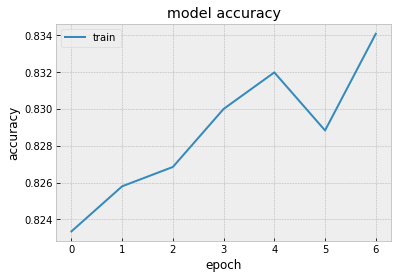

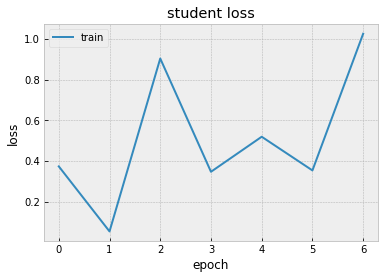

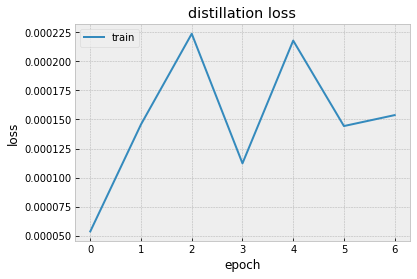

In [ ]:
#summary history for accuracy
plt.plot(hist3.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for loss
plt.plot(hist3.history['student_loss'])
#plt.plot(history.history['val_loss'])
plt.title('student loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for distillation loss
plt.plot(hist3.history['distillation_loss'])
#plt.plot(history.history['val_loss'])
plt.title('distillation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
distiller_2.evaluate(test_data_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1070/1070 [==============================] - 171s 159ms/step - sparse_categorical_accuracy: 0.8266 - student_loss: 0.4982


[0.8266152739524841, 0.33180418610572815]

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
#getting the true class labels
y_true_labels = test_data_generator.classes
#y_true_labels = testgen.class_indices
print(y_true_labels)
type(y_true_labels)

[2, 3, 1, 2, 3, 3, 3, 3, 0, 3, 2, 1, 1, 3, 2, 1, 4, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 3, 4, 4, 3, 1, 2, 3, 3, 3, 1, 3, 2, 3, 3, 3, 2, 1, 2, 1, 3, 2, 4, 3, 3, 2, 3, 3, 2, 3, 2, 4, 1, 1, 3, 3, 3, 2, 1, 3, 1, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 1, 3, 4, 3, 3, 3, 3, 1, 3, 3, 1, 2, 2, 3, 4, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 4, 2, 3, 4, 1, 3, 3, 4, 3, 4, 4, 3, 3, 2, 3, 3, 3, 4, 3, 0, 4, 0, 3, 3, 4, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 2, 3, 1, 4, 3, 3, 0, 2, 3, 3, 3, 4, 4, 2, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 2, 3, 4, 3, 4, 3, 3, 3, 2, 0, 2, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 2, 4, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 2, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 3, 0, 3, 3, 3, 3, 1, 4, 3, 2, 2, 3, 3, 1, 4, 2, 2, 3, 3, 3, 3, 2, 4, 3, 4, 1, 3, 4, 3, 3, 3, 3, 3, 1, 4, 3, 4, 4, 3, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 0, 4, 3, 3, 2, 3, 0, 4, 2, 2, 3, 3, 

list

In [ ]:
TEST_STEPS = len(test_df) / BATCH_SIZE

In [ ]:
#Y prediction
Y_pred = distiller_2.predict_generator(test_data_generator, TEST_STEPS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_true_labels, y_pred))

Confusion Matrix
[[  25   34   23  299   52]
 [  57   75   48  600  112]
 [  56   57   70  654  115]
 [ 280  422  327 3472  725]
 [  40   98   54  705  159]]


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print('Classification Report')
target_names = ['0','1','2','3','4']
print(classification_report(test_data_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.05      0.06      0.06       433
           1       0.11      0.08      0.10       892
           2       0.13      0.07      0.09       952
           3       0.61      0.66      0.63      5226
           4       0.14      0.15      0.14      1056

    accuracy                           0.44      8559
   macro avg       0.21      0.21      0.20      8559
weighted avg       0.42      0.44      0.43      8559



**Temperature = 5**

In [ ]:
#construct the distiller class
class Distiller3(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller3, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=5,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller3, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature


    def train_step(self, data):
        # Unpack data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    
    def call (self, data):
        #teacher_predictions = self.teacher(data, training=False)
        student_predictions = self.student(data, training=True)
        return student_predictions


    def test_step(self, data):
        # Unpack the data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
# Initialize and compile distiller
distiller_3 = Distiller3(student=student, teacher=teacher)
hist = distiller_3.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1, temperature = 10
  
)

In [ ]:
#Early stopping using student loss
#call backs
model_save = tf.keras.callbacks.ModelCheckpoint('./teacher3_resnet_50.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'distillation_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'distillation_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [ ]:
# Distill teacher to student
hist4 = distiller_3.fit(train_data_generator, epochs=30,callbacks=[model_save, early_stop], shuffle=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/30
1070/1070 [==============================] - 337s 314ms/step - sparse_categorical_accuracy: 0.8275 - student_loss: 0.4984 - distillation_loss: 1.3675e-04

Epoch 00001: distillation_loss improved from inf to 0.00010, saving model to ./teacher3_resnet_50.h5
Epoch 2/30
1070/1070 [==============================] - 340s 317ms/step - sparse_categorical_accuracy: 0.8212 - student_loss: 0.4878 - distillation_loss: 1.3615e-04

Epoch 00002: distillation_loss did not improve from 0.00010
Epoch 3/30
1070/1070 [==============================] - 337s 315ms/step - sparse_categorical_accuracy: 0.8222 - student_loss: 0.4930 - distillation_loss: 1.3462e-04

Epoch 00003: distillation_loss did not improve from 0.00010
Epoch 4/30
1070/1070 [==============================] - 338s 316ms/step - sparse_categorical_accuracy: 0.8352 - student_loss: 0.4823 - distillation_loss: 1.3317e-04

Epoch 00004: distillation_loss did not improve from 0.00010
Epoch 5/30
1070/1070 [==============================] -

In [ ]:
hist4.history

{'distillation_loss': [9.728244185680524e-05,
  0.00019298655388411134,
  0.00020611894433386624,
  0.00024436344392597675,
  0.0001423196226824075,
  2.214952473877929e-05],
 'sparse_categorical_accuracy': [0.8233438730239868,
  0.8290688395500183,
  0.8290688395500183,
  0.831756055355072,
  0.8307045102119446,
  0.8352611064910889],
 'student_loss': [1.1893901824951172,
  0.4251360595226288,
  0.6735725998878479,
  1.0233842134475708,
  0.4194595515727997,
  0.27905258536338806]}

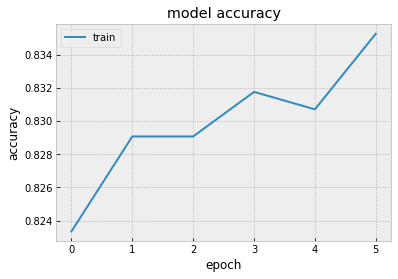

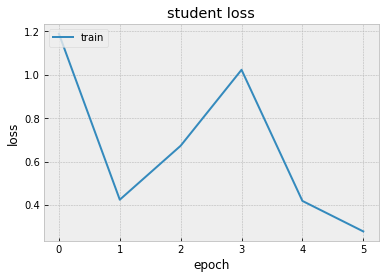

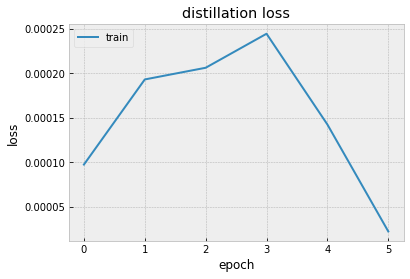

In [ ]:
#summary history for accuracy
plt.plot(hist4.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for loss
plt.plot(hist4.history['student_loss'])
#plt.plot(history.history['val_loss'])
plt.title('student loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for distillation loss
plt.plot(hist4.history['distillation_loss'])
#plt.plot(history.history['val_loss'])
plt.title('distillation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
distiller_3.evaluate(test_data_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1070/1070 [==============================] - 170s 159ms/step - sparse_categorical_accuracy: 0.8304 - student_loss: 0.4892


[0.8303540349006653, 0.10796470195055008]

In [ ]:
# Initialize and compile distiller
distiller_3_1 = Distiller3(student=student, teacher=teacher)
hist = distiller_3_1.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1, temperature = 10)

In [ ]:
#Early stopping using student loss
#call backs
model_save = tf.keras.callbacks.ModelCheckpoint('./teacher4_resnet_50.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'student_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'student_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [ ]:
hist6 = distiller_3_1.fit(train_data_generator, epochs=30, shuffle=False, callbacks=[model_save, early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/30
1070/1070 [==============================] - 340s 318ms/step - sparse_categorical_accuracy: 0.8309 - student_loss: 0.5006 - distillation_loss: 1.3756e-04

Epoch 00001: student_loss improved from inf to 0.35579, saving model to ./teacher4_resnet_50.h5
Epoch 2/30
1070/1070 [==============================] - 338s 316ms/step - sparse_categorical_accuracy: 0.8359 - student_loss: 0.4837 - distillation_loss: 1.3253e-04

Epoch 00002: student_loss improved from 0.35579 to 0.23640, saving model to ./teacher4_resnet_50.h5
Epoch 3/30
1070/1070 [==============================] - 337s 315ms/step - sparse_categorical_accuracy: 0.8326 - student_loss: 0.4792 - distillation_loss: 1.3203e-04

Epoch 00003: student_loss did not improve from 0.23640
Epoch 4/30
1070/1070 [==============================] - 338s 316ms/step - sparse_categorical_accuracy: 0.8370 - student_loss: 0.4860 - distillation_loss: 1.2988e-04

Epoch 00004: student_loss improved from 0.23640 to 0.21438, saving model to ./teacher

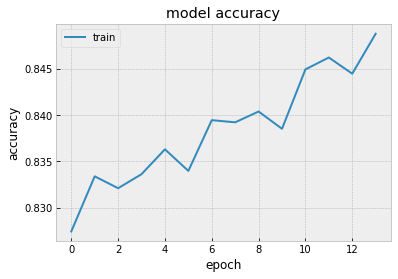

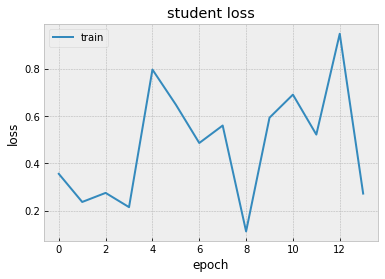

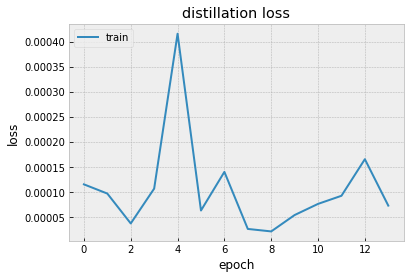

In [ ]:
#summary history for accuracy
plt.plot(hist6.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for loss
plt.plot(hist6.history['student_loss'])
#plt.plot(history.history['val_loss'])
plt.title('student loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for distillation loss
plt.plot(hist6.history['distillation_loss'])
#plt.plot(history.history['val_loss'])
plt.title('distillation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
hist6.history

{'distillation_loss': [0.00011588666529860348,
  9.750959725352004e-05,
  3.7957506719976664e-05,
  0.00010735773685155436,
  0.0004160334065090865,
  6.375884549925104e-05,
  0.00014072867634240538,
  2.7024883820558898e-05,
  2.2081954739405774e-05,
  5.472421980812214e-05,
  7.694082160014659e-05,
  9.309580491390079e-05,
  0.00016601420065853745,
  7.35194917069748e-05],
 'sparse_categorical_accuracy': [0.8274331092834473,
  0.8333917260169983,
  0.8321065306663513,
  0.8336254358291626,
  0.8363126516342163,
  0.8339759111404419,
  0.8394672274589539,
  0.8392335772514343,
  0.8404018878936768,
  0.838532567024231,
  0.8449585437774658,
  0.8462437391281128,
  0.844491183757782,
  0.8488141298294067],
 'student_loss': [0.3557876944541931,
  0.2363954782485962,
  0.27489081025123596,
  0.21437504887580872,
  0.7981797456741333,
  0.6493223905563354,
  0.486614853143692,
  0.5607711672782898,
  0.11142062395811081,
  0.5940126180648804,
  0.6918596029281616,
  0.5223895907402039,
  

In [ ]:
distiller_3_1.evaluate(test_data_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1070/1070 [==============================] - 170s 158ms/step - sparse_categorical_accuracy: 0.8319 - student_loss: 0.4910


[0.8318728804588318, 0.37480539083480835]

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
#getting the true class labels
y_true_labels = test_data_generator.classes
#y_true_labels = testgen.class_indices
print(y_true_labels)
type(y_true_labels)

[2, 3, 1, 2, 3, 3, 3, 3, 0, 3, 2, 1, 1, 3, 2, 1, 4, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 3, 4, 4, 3, 1, 2, 3, 3, 3, 1, 3, 2, 3, 3, 3, 2, 1, 2, 1, 3, 2, 4, 3, 3, 2, 3, 3, 2, 3, 2, 4, 1, 1, 3, 3, 3, 2, 1, 3, 1, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 1, 3, 4, 3, 3, 3, 3, 1, 3, 3, 1, 2, 2, 3, 4, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 4, 2, 3, 4, 1, 3, 3, 4, 3, 4, 4, 3, 3, 2, 3, 3, 3, 4, 3, 0, 4, 0, 3, 3, 4, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 2, 3, 1, 4, 3, 3, 0, 2, 3, 3, 3, 4, 4, 2, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 2, 3, 4, 3, 4, 3, 3, 3, 2, 0, 2, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 2, 4, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 2, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 3, 0, 3, 3, 3, 3, 1, 4, 3, 2, 2, 3, 3, 1, 4, 2, 2, 3, 3, 3, 3, 2, 4, 3, 4, 1, 3, 4, 3, 3, 3, 3, 3, 1, 4, 3, 4, 4, 3, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 0, 4, 3, 3, 2, 3, 0, 4, 2, 2, 3, 3, 

list

In [ ]:
TEST_STEPS = len(test_df) / BATCH_SIZE

In [ ]:
#Y prediction
Y_pred = distiller_3.predict_generator(test_data_generator, TEST_STEPS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_true_labels, y_pred))

Confusion Matrix
[[  17   37   31  292   56]
 [  23   85   74  617   93]
 [  29   92   55  648  128]
 [ 195  497  410 3435  689]
 [  40   95   85  698  138]]


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print('Classification Report')
target_names = ['0','1','2','3','4']
print(classification_report(test_data_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.06      0.04      0.05       433
           1       0.11      0.10      0.10       892
           2       0.08      0.06      0.07       952
           3       0.60      0.66      0.63      5226
           4       0.12      0.13      0.13      1056

    accuracy                           0.44      8559
   macro avg       0.19      0.20      0.19      8559
weighted avg       0.41      0.44      0.42      8559



In [ ]:
#Y prediction
Y_pred_1 = distiller_3_1.predict_generator(test_data_generator, TEST_STEPS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
y_pred_1 = np.argmax(Y_pred_1, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_true_labels, y_pred_1))

Confusion Matrix
[[  15   40   36  285   57]
 [  28   81   67  594  122]
 [  33   89   59  661  110]
 [ 205  493  421 3435  672]
 [  37  122   72  686  139]]


In [ ]:
print('Classification Report')
target_names = ['0','1','2','3','4']
print(classification_report(test_data_generator.classes, y_pred_1, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.05      0.03      0.04       433
           1       0.10      0.09      0.09       892
           2       0.09      0.06      0.07       952
           3       0.61      0.66      0.63      5226
           4       0.13      0.13      0.13      1056

    accuracy                           0.44      8559
   macro avg       0.19      0.20      0.19      8559
weighted avg       0.41      0.44      0.42      8559

